# Physics Informed Neural Networks (PINN)

**Students:**

Guilherme Marim - RA: 232092

## Objective

Get a **PINN** to solve the Buckley-Leverett equation for the Non-convex flux with diffusion term.

Buckley-Leverett equation: 

\begin{equation}
    u_{t} + {f_w}'(u)u_{x} = \epsilon u_{xx}
\end{equation}

Initial and boundary conditions:

\begin{equation}
    u(x,t) = 0, \forall x \ and \ t = 0,
\end{equation}

\begin{equation}
    u(x,t) = 1, x = 0 \ and \ t > 0.
\end{equation}

Analytical solution non-convex flux:


\begin{equation}
    f_w(u) = \frac{u^{2}}{u^{2} + \frac{(1-u)^2}{M}},
\end{equation}

where $$M = 1$$


**This work was based on the following articles:**

1.	M. Raissi, P. Perdikaris, and G. E. Karniadakis, “Physics Informed Deep Learning (Part I): Data-driven Solutions of Nonlinear Partial Differential Equations”, **arXiv**: 1711.10561v1, 28-Nov-2017.


2.	M. Raissi, P. Perdikaris, and G. E. Karniadakis, “Physics Informed Deep Learning (Part II): Data-driven Discovery of Nonlinear Partial Differential Equations”, **arXiv**: 1711.10556v1, 28-Nov-2017.


3.	O. Fuks and H. A. Tchelepi, “Limitations of Physics Informed Machine Learning for Nonlinear Two-Phase Transport in Porous Media”, **ResearchGate preprint publication** https://www.researchgate.net/publication/343111185, 2020


## Loading Libraries

To develop this work, based on articles [1],[2], we used the 1.15 Tensorflow version.

In [1]:
!pip install tensorflow==1.15

In [2]:
!pip install pyDOE

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sympy import *

np.random.seed(1234)
tf.set_random_seed(1234)

In [4]:
print(tf.__version__)

1.15.0


## Plot functions

In [5]:
def plot_data_time_serie(x_grid, u_final):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(x_grid, u_final[25], linewidth = 4)
    plt.title('t = 0.25')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)

    plt.subplot(1, 3, 2)
    plt.plot(x_grid, u_final[50], linewidth = 4)
    plt.title('t = 0.5')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)

    plt.subplot(1, 3, 3)
    plt.plot(x_grid, u_final[75], linewidth = 4)
    plt.title('t = 0.75')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.show()

In [6]:
def plot_data_time_serie_compare(x_grid, u_original, u_predicted):
    plt.figure(figsize=(15, 4))
    plt.subplot(1, 3, 1)
    plt.plot(x_grid, u_original[25], linewidth = 4, label="Original")
    plt.plot(x_grid, u_predicted[25], '--r', linewidth = 4, label="Predicted")
    plt.legend(loc="best")
    plt.title('t = 0.25')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)

    plt.subplot(1, 3, 2)
    plt.plot(x_grid, u_original[50], linewidth = 4, label="Original")
    plt.plot(x_grid, u_predicted[50], '--r', linewidth = 4, label="Predicted")
    plt.legend(loc="best")
    plt.title('t = 0.5')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)

    plt.subplot(1, 3, 3)
    plt.plot(x_grid, u_original[75], linewidth = 4, label="Original")
    plt.plot(x_grid, u_predicted[75], '--r', linewidth = 4, label="Predicted")
    plt.legend(loc="best")
    plt.title('t = 0.75')
    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.xlim(-0.1,1.1)
    plt.ylim(-0.1,1.1)
    plt.show()

In [7]:
def plot_data(X, T, U, title=''):
    fig, ax = plt.subplots(figsize=(12, 4))

    surf = ax.contourf(X, T, U, cmap=plt.get_cmap("seismic"))

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.title(title)
    plt.xlabel('Space (x)')
    plt.ylabel('Time (t)')
    plt.tight_layout()

In [8]:
def plot_data_compare(X, T, U, U_predicted, title_1='Original data', title_2='Predicted data', title_3='Absolute difference'):
    fig, ax = plt.subplots(1,3,sharey=True,figsize=(15, 7))    

    surf1 = ax[0].contourf(X, T, U, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf1, ax=ax[0], ticks=None)
    ax[0].set_title(title_1)
    ax[0].set_ylabel('Time')

    surf2 = ax[1].contourf(X, T, U_predicted, cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf2, ax=ax[1])
    ax[1].set_title(title_2)

    surf3 = ax[2].contourf(X, T, abs(U - U_predicted), cmap=plt.get_cmap("seismic"))
    fig.colorbar(surf3, ax=ax[2])
    ax[2].set_title(title_3)

    plt.tight_layout()

    print(f'Mean error {round(abs(U - U_predicted).mean(), 2)}')

## Loading Dataset Buckley-Leverett

In [9]:
X = np.load('/content/BL_X.npy')
T = np.load('/content/BL_T.npy')
U = np.load('/content/BL_U.npy')

In [10]:
t = T[:,0][:,None]
x = X[0,:][:,None]

print(t.shape)
print(x.shape)
print(U.shape)

(100, 1)
(100, 1)
(100, 100)


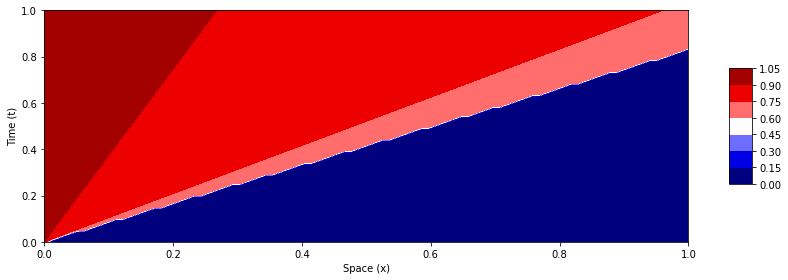

In [11]:
plot_data(X, T, U)

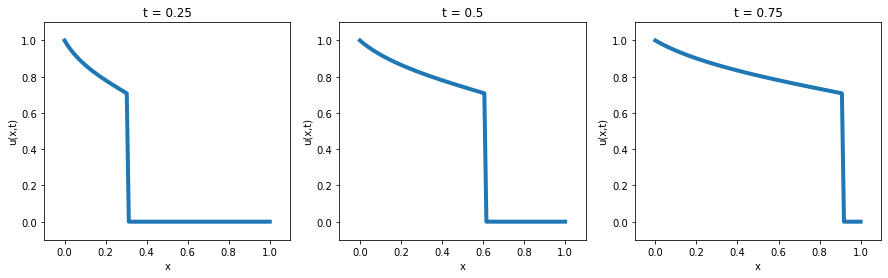

In [12]:
plot_data_time_serie(x, U)

## Preparing input and output data for neural network training

In [13]:
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = U.flatten()[:,None]

print(X_star.shape)
print(u_star.shape)

(10000, 2)
(10000, 1)


In [14]:
# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

print(lb)
print(ub)

[0. 0.]
[1. 1.]


## Initial e boundary conditions points and collocation points

For the training data we use $N_u = 300$ randomly distributed points on initial and
boundary conditions, and $N_r = 10.000$ collocation points for the residual term, sampled randomly over the interior of
the domain $x \in [0,1], t \in [0,1]$ as in the article[3]

In [15]:
N_u = 300
N_f = 10000

In [16]:
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = U[0:1,:].T
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = U[:,0:1]
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = U[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]


print(X_u_train.shape)
print(u_train.shape)
print(X_f_train.shape)

(300, 2)
(300, 1)
(10300, 2)


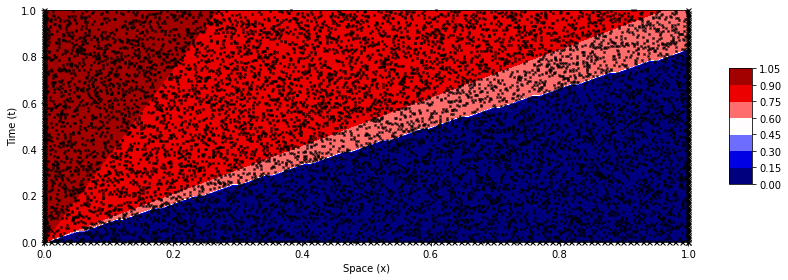

In [17]:
fig, ax = plt.subplots(figsize=(12,4))

surf = ax.contourf(X, T, U, cmap=plt.get_cmap("seismic"))
ax.plot(X_u_train[:,0], X_u_train[:,1], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 5, clip_on = False)
ax.plot(X_f_train[:,0], X_f_train[:,1], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 2, clip_on = False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.tight_layout()

## Function for Non-convex flux and your derivative

In [18]:
# fw(u) function for Non-convex flux
def fw_non_convex_flux(u,M): 
    return (u**2)/((u**2) + ((1-u)**2)/M)

In [19]:
# derivada de primera ordem de fw(u), em relação a u para fluxo não convexo
def diff_fw_non_convex_flux(u,M):
    u_symbol = symbols('u')
    
    eq_fw = (u_symbol**2)/((u_symbol**2) + ((1-u_symbol)**2)/M)
    fw = lambdify(u_symbol, eq_fw, 'numpy')
    
    eq_fw_linha = eq_fw.diff(u_symbol)    
    fw_linha = lambdify(u_symbol, eq_fw_linha, 'numpy')
    
    return fw_linha(u)

## Creating the PINN class to make the training

In [20]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, epsilon):
        
        self.lb = lb
        self.ub = ub
    
        self.x_u = X_u[:,0:1]
        self.t_u = X_u[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u = u
        
        self.layers = layers
        self.epsilon = epsilon
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_u_tf = tf.placeholder(tf.float32, shape=[None, self.x_u.shape[1]])
        self.t_u_tf = tf.placeholder(tf.float32, shape=[None, self.t_u.shape[1]])        
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)         
        
        self.loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) + \
                    tf.reduce_mean(tf.square(self.f_pred))
               
                
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

                
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return u
    
    def net_f(self, x,t):
        u = self.net_u(x,t)
        
        M = 1
        fw = fw_non_convex_flux(u,M)
        fw_u = tf.gradients(fw, u)[0]
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        
        f = u_t + fw_u*u_x - self.epsilon*u_xx
        
        return f
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):

        tf_dict = {self.x_u_tf: self.x_u, self.t_u_tf: self.t_u, self.u_tf: self.u,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % (it, loss_value, elapsed))
                start_time = time.time()
        
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback)
      
    def predict(self, X_star):
                
        u_star = self.sess.run(self.u_pred, {self.x_u_tf: X_star[:,0:1], self.t_u_tf: X_star[:,1:2]})  
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
               
        return u_star, f_star

## Training the model

We use to train the model the architecture proposed by the article[1],[3], with 8 deep layers with 20 neurons each, the input layer inputting the space and time data, and the output layer outputting the value of the U function

**We considered two different value to the diffusion term $\epsilon$.**

**For the first training the diffusion term is $\epsilon = 1.0 \times 10^{-2}$**

In [21]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

epsilon = 1.0e-02

In [22]:
model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, epsilon)
    
start_time = time.time()                
model.train(0)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

A saída de streaming foi truncada nas últimas 5000 linhas.
Loss: 0.080076806
Loss: 0.08001939
Loss: 0.07994155
Loss: 0.07978237
Loss: 0.07945784
Loss: 0.079022706
Loss: 0.07891892
Loss: 0.07876372
Loss: 0.078283645
Loss: 0.077738635
Loss: 0.077836245
Loss: 0.077384576
Loss: 0.077051066
Loss: 0.07674446
Loss: 0.07642503
Loss: 0.07724768
Loss: 0.07603894
Loss: 0.07579773
Loss: 0.075636566
Loss: 0.07552155
Loss: 0.07540502
Loss: 0.075141706
Loss: 0.074911274
Loss: 0.07469003
Loss: 0.07465488
Loss: 0.07460057
Loss: 0.07451764
Loss: 0.074396014
Loss: 0.0740664
Loss: 0.07357977
Loss: 0.0727631
Loss: 0.07693482
Loss: 0.07218145
Loss: 0.07337524
Loss: 0.07204875
Loss: 0.071768835
Loss: 0.07150382
Loss: 0.07112701
Loss: 0.070337154
Loss: 0.2447223
Loss: 0.07068088
Loss: 0.07000737
Loss: 0.07087373
Loss: 0.06935795
Loss: 0.06736435
Loss: 0.07202565
Loss: 0.06493836
Loss: 0.063406646
Loss: 0.5452366
Loss: 0.066759795
Loss: 0.06289643
Loss: 0.069603786
Loss: 0.059438076
Loss: 0.06176374
Loss: 0.05

In [23]:
u_pred, f_pred = model.predict(X_star)
        
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(U - U_pred)

Error u: 8.769775e-02


Mean error 0.02


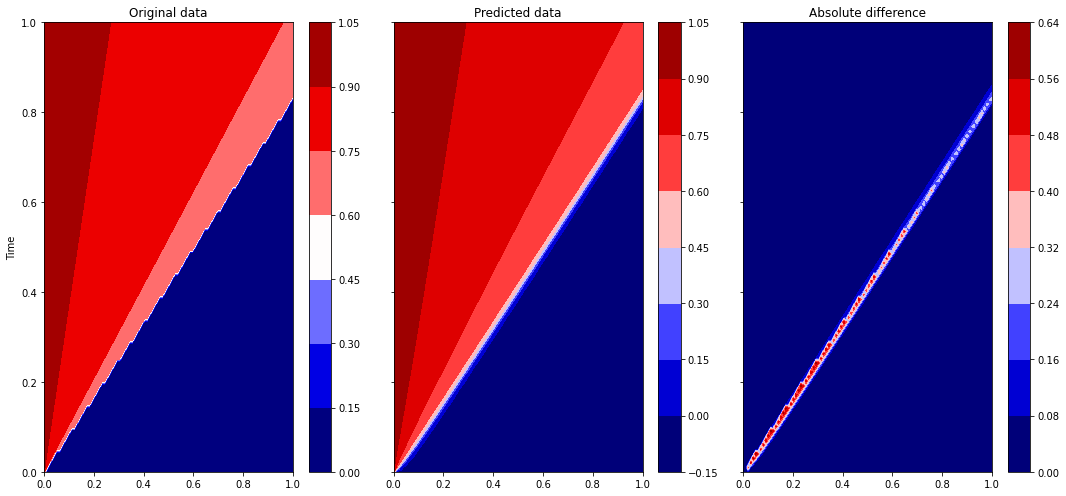

In [24]:
plot_data_compare(X, T, U, U_pred)

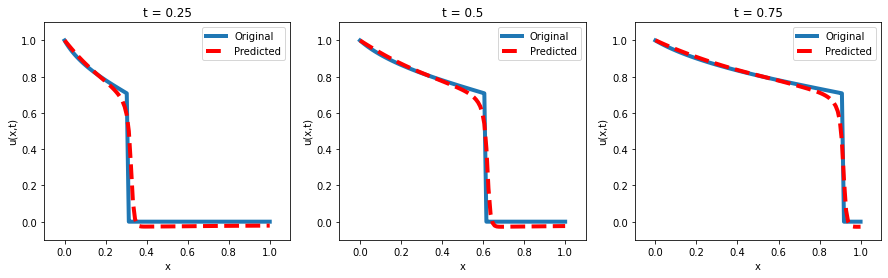

In [25]:
plot_data_time_serie_compare(x, U, U_pred)

**For the second training the diffusion term is $\epsilon = 2.5 \times 10^{-3}$**

In [26]:
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

epsilon = 2.5e-03

In [27]:
model2 = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, epsilon)
    
start_time = time.time()                
model2.train(0)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

A saída de streaming foi truncada nas últimas 5000 linhas.
Loss: 0.04998264
Loss: 0.049968526
Loss: 0.04995047
Loss: 0.049931746
Loss: 0.049907163
Loss: 0.049878236
Loss: 0.04984797
Loss: 0.049878612
Loss: 0.049839396
Loss: 0.049823552
Loss: 0.04981768
Loss: 0.04980511
Loss: 0.049800187
Loss: 0.049783077
Loss: 0.049758997
Loss: 0.04973238
Loss: 0.04971108
Loss: 0.049690373
Loss: 0.049670752
Loss: 0.049653474
Loss: 0.04962564
Loss: 0.049601696
Loss: 0.049644675
Loss: 0.049591642
Loss: 0.04955749
Loss: 0.04951241
Loss: 0.049476113
Loss: 0.049484257
Loss: 0.049439847
Loss: 0.0493982
Loss: 0.049368612
Loss: 0.049372397
Loss: 0.049337767
Loss: 0.049325585
Loss: 0.049307868
Loss: 0.049296655
Loss: 0.049287543
Loss: 0.049270935
Loss: 0.049245283
Loss: 0.052751377
Loss: 0.049222108
Loss: 0.04918039
Loss: 0.04918709
Loss: 0.0491576
Loss: 0.04914293
Loss: 0.049124856
Loss: 0.049095467
Loss: 0.049274012
Loss: 0.04908913
Loss: 0.04905163
Loss: 0.049035653
Loss: 0.04897285
Loss: 0.048931494
Loss: 0

In [28]:
u_pred2, f_pred2 = model2.predict(X_star)
        
error_u2 = np.linalg.norm(u_star-u_pred2,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u2))                     

U_pred2 = griddata(X_star, u_pred2.flatten(), (X, T), method='cubic')
Error = np.abs(U - U_pred2)

Error u: 5.118573e-02


Mean error 0.01


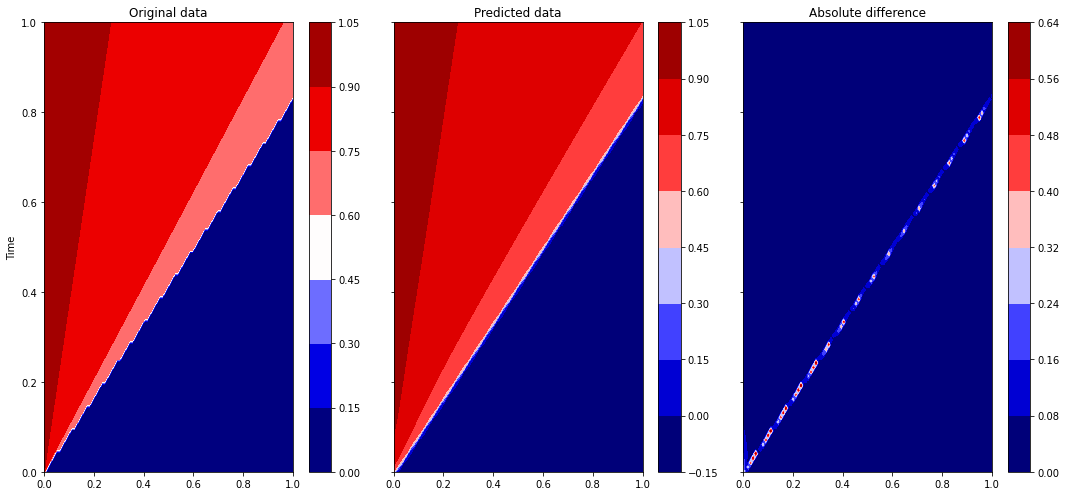

In [29]:
plot_data_compare(X, T, U, U_pred2)

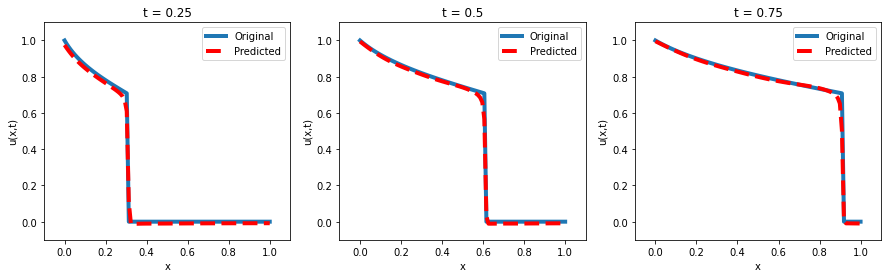

In [30]:
plot_data_time_serie_compare(x, U, U_pred2)

## Results

For the first training considering the diffusion term $\epsilon = 1.0 \times 10^{-2}$, we got a Mean Square Error (MSE) of approximately $9.8 \times 10^{-4}$ and the relative $l^2$ norm ($l_r^2$) of approximately $8.77 \times 10^{-2}$.

Comparing with the second training we have the $MSE = 2.6 \times 10^{-3}$ and the $l_r^2 = 5.12 \times 10^{-2}$ using the diffusion term $\epsilon = 2.5 \times 10^{-3}$.

So like decribed in the article[3], we got the best results with the $\epsilon = 2.5 \times 10^{-3}$.

**Plotting the predicted time serie with the $\epsilon = 1.0 \times 10^{-2}$**

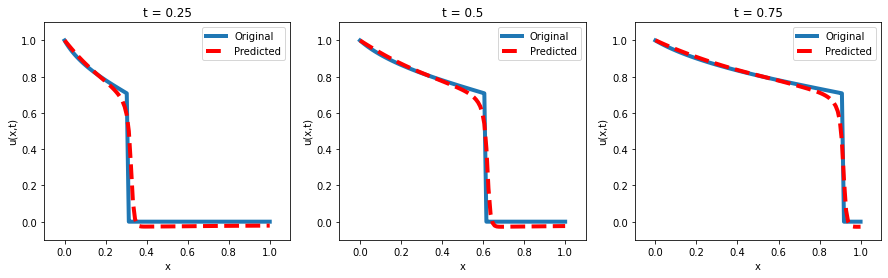

In [31]:
plot_data_time_serie_compare(x, U, U_pred)

**Plotting the predicted time serie with the $\epsilon = 2.5 \times 10^{-3}$**

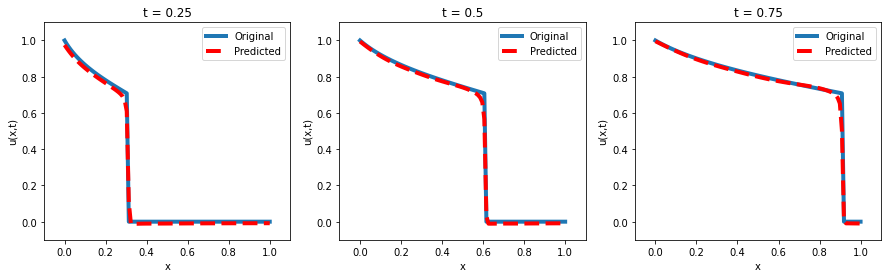

In [32]:
plot_data_time_serie_compare(x, U, U_pred2)